# Get experiments

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


# Extend the experiment df with the experiment processed results

In [6]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [7]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            norm_y = [yi/max(y) for yi in y]
            norm_area = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=1)
            results_df = pd.DataFrame({'Temperature(C)': [T], 
                                        'Doping(%)': [d], 
                                        'Time(min)': [t], 
                                        'Peak1': [peaks[0]], 
                                        'Peak2': [peaks[1]], 
                                        'Area1': [areas[0]], 
                                        'Area2': [areas[1]],
                                        'Distance_peaks': [peaks[1]-peaks[0]],
                                        'ratioP2P1': [areas[1]/areas[0]],
                                        'Wavelengths': [x],
                                        'Fluorescence': [y],
                                        'Fluorescence_norm': [norm_y],}) # we can add other labels here
            new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

# Entire espectra

In [9]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')


# Creating bolift pool

In [11]:
experiments.head()

,Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment
0,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,1.00,1.4,60,25,1_NPL-4_(5-31-22)
1,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,2.50,3.4,60,25,1_NPL-4_(5-31-22)
2,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,5.00,6.8,60,25,1_NPL-4_(5-31-22)
3,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,10.00,13.7,60,25,1_NPL-4_(5-31-22)
4,18.8,14.04,100x,0.175,0.25,1.75,0.0007,3.5,20,8,0.25,3.0,60,25,2_NPL-4_(6-1-22)


In [12]:
import itertools
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

def get_partial_pool(experiments, feats):
    dict_df = experiments.groupby(by=feats).size().reset_index()[feats].to_dict()
    return [{k:v[i] for (k,v) in zip(dict_df.keys(), dict_df.values())} for i in range(len(list(dict_df.values())[0]))]

def explode_dict(dict):
    return [{k:v[i] for (k,v) in zip(dict.keys(), dict.values())} for i in range(len(list(dict.values())[0]))]

features = experiments.keys()[:-1]
feats_1=features[0:2]
feats_2=features[2:6]
feats_3=features[6:12]
feats_4=features[12:14]

pool_p1 = get_partial_pool(experiments, feats_1.to_list())
pool_p2 = get_partial_pool(experiments, feats_2.to_list())
pool_p3 = get_partial_pool(experiments, feats_3.to_list())
pool_p4 = {
    "Time(min)": [10, 60, 180],
    "Temperature(C)": [0, 25, 50],
}
pool_p4 = [{"Time(min)": v1, "Temperature(C)": v2} for (v1,v2) in itertools.product(*pool_p4.values())]


iter = itertools.product(pool_p1, pool_p2, pool_p3, pool_p4)

pool_list = []
for props in iter:
    d = {}
    for prop in props:
        d.update(prop)
    pool_list.append(prompt_template.format(**d))

with open('Data/pool.txt', 'w') as output:
    output.write('\n'.join(pool_list))

pool = bolift.Pool(pool_list)
cloudpickle.dump(pool, open('Data/pool.pkl', 'wb'))

/home/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValidationError: 1 validation error for OpenAIEmbeddings
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass  `openai_api_key` as a named parameter. (type=value_error)

# Analyzing the data

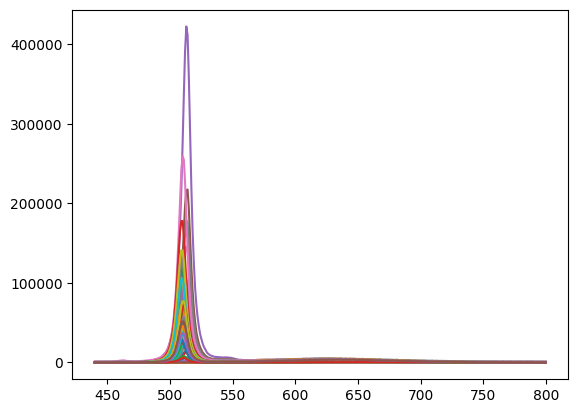

In [18]:
df = pd.read_csv('Data/spectra_data.csv')

for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    plt.plot(df['Wavelength(nm)'], df['Fluorescence'], label=group[0])
    # plt.legend()
    # break

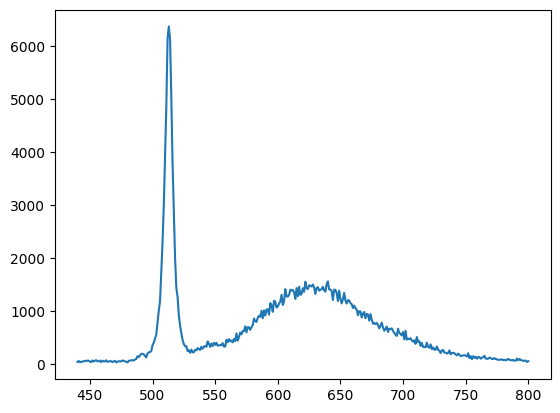

In [19]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

sample = df.iloc[0]
w = [float(a) for a in sample['Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]

plt.plot(w, i, color="C0")

In [21]:
df[['Peak1', "Peak2", "Area1", "Area2", "ratioP2P1"]].describe()

,Peak1,Peak2,Area1,Area2,ratioP2P1
count,56.000000,56.000000,5.600000e+01,56.000000,56.000000
mean,510.982143,624.964286,7.803343e+05,257179.276786,1.559201
std,3.205059,16.252512,8.096359e+05,144278.747123,3.042757
min,491.000000,550.000000,4.855500e+03,27103.000000,0.061448
25%,510.000000,618.000000,3.049756e+05,143051.500000,0.208425
50%,511.000000,625.500000,5.588022e+05,239792.500000,0.473172
75%,513.000000,630.500000,1.059979e+06,358510.125000,0.871267
max,514.000000,671.000000,4.619610e+06,525529.000000,13.367074


/home/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

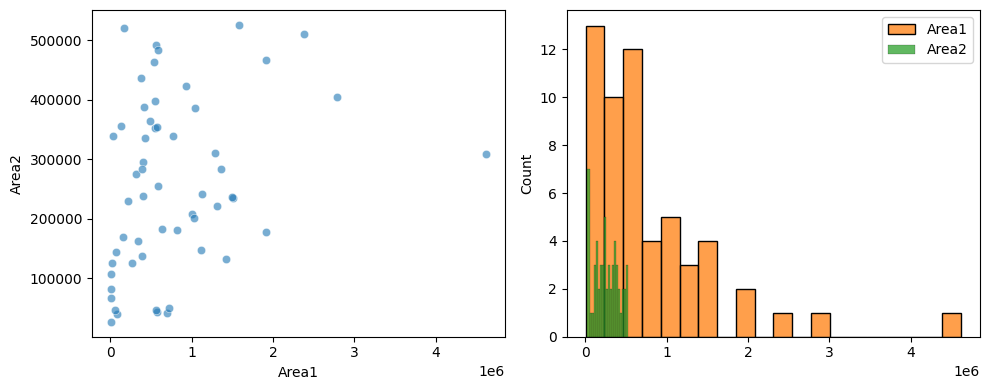

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels_auc1 = df['Area1'].to_list()
labels_auc2 = df['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_auc1, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('Area1')
ax1.set_ylabel('Area2')

sns.histplot(labels_auc1, bins=20, label='Area1', ax=ax2, color='C1')
sns.histplot(labels_auc2, bins=20, label='Area2', ax=ax2, color='C2')
ax2.legend()

plt.tight_layout()
plt.show()


In [27]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
import numpy as np
import base64
from io import BytesIO

plotly_df = pd.DataFrame({
    "Area1": df['Area1'].tolist(),
    "Area2": df['Area2'].tolist(),
    "customdata": list(zip(
        df['Wavelengths'].tolist(), 
        df['Fluorescence'].tolist()
        ))
})
fig = px.scatter(plotly_df, x="Area1", y="Area2", custom_data=["customdata"])
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=10)

# Create dash app
app = dash.Dash(__name__)

# Create app layout to show dash graph
app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id="graph_interaction",
            figure=fig,
        )
    ], style={'width': '60%', 'display': 'inline-block'}),

    html.Div([
        html.Img(id='image', src='')
    ], style={'width': '35%', 'display': 'inline-block', 'padding': "20px"})
])

def plot_and_encode_image(data):
    wv = list(map(float, data[0].strip('[]').split(',')))
    fl = list(map(float, data[1].strip('[]').split(',')))
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(wv, fl)
    plt.close(fig)
    
    # Convert plot to PNG image
    buf = BytesIO()
    fig.savefig(buf, format="png")
    
    # Encode PNG image to base64 string
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    return "data:image/png;base64,{}".format(data)

@app.callback(
    Output('image', 'src'),
    Input('graph_interaction', 'hoverData'))
def update_image(hoverData): 
    if hoverData:
        data_to_plot = hoverData["points"][0]["customdata"][0]
        return plot_and_encode_image(data_to_plot)
    else:
        raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=True)